In [1]:
from googleapiclient.discovery import build
import config
from datetime import datetime
import json
import os
import pandas as pd

In [2]:
KIDS = config.KIDS

In [3]:
class LinkCollector(object):
    
    '''
    This class used to search for related links of certain key words from youtube
    '''
    def __init__(self, query_key_word):

        self.query_key_word = query_key_word
        self.df_list = []
        self.resource = build('youtube', 'v3', developerKey=KIDS)
        self.cur_res = '1'
        self.res = []

    def search(self, next_page_token = None):
        
        cur_page_token = next_page_token
        import copy
        req = self.resource.search().list(part='snippet',
                                          maxResults = 50,
                                          order = 'relevance',
                                          pageToken = next_page_token,
                                          q=self.query_key_word,
                                          relevanceLanguage = 'en',
                                          type = 'video',
                                          videoCaption = 'any'
                                          )
        res = req.execute()
        self.cur_res = res
        self.res.append(copy.deepcopy(self.cur_res))
        self.__persist_data(res, cur_page_token)

    def __generate_datetime(self, year, month, day):

        return datetime(year=year, month=month, day = day).strftime('%Y-%m-%dT%H:%M:%SZ')
    
    def __persist_data(self, res, cur_page_token):
        if cur_page_token is None:
            cur_page_token = ''
        json.dump(res, open('youtube_request_' + cur_page_token +'.json' , 'a+'))
        

In [4]:
import re
from json import JSONDecoder, JSONDecodeError

def stream_json(file_obj, buf_size=1024, decoder=JSONDecoder()):

    ### deal with multiple json object in on file

    NOT_WHITESPACE = re.compile(r"[^\s]")

    buf = ""
    ex = None
    while True:
        block = file_obj.read(buf_size)
        if not block:
            break
        buf += block
        pos = 0
        while True:
            match = NOT_WHITESPACE.search(buf, pos)
            if not match:
                break
            pos = match.start()
            try:
                obj, pos = decoder.raw_decode(buf, pos)
            except JSONDecodeError as e:
                ex = e
                break
            else:
                ex = None
                yield obj
        buf = buf[pos:]
    if ex is not None:
        raise ex

In [5]:
def extract_video_from_json(directory):
    
    ### extract all the videos ids from the saved json file in a directory
    videos = []
    for entry in os.scandir(directory):
        if entry.path.endswith(".json") and entry.is_file():
            items_ls = []
            try:
                items_ls.extend([json.load(open(entry, 'r'))])
            except:
                for items_piece in stream_json(open(entry, 'r')):
                    items_ls.append(items_piece)

            new_videos = [item['id']['videoId'] for items in items_ls for item in items['items']]
            videos.extend(new_videos)

    return videos

In [6]:
videos = extract_video_from_json('/Users/QiaoLiu1/kids_tube/collected_link_json')

In [7]:
class VideoDetailsCollector(object):

    '''
    This class is used to search for detailed information of each videos from youtube
    '''
    def __init__(self, video_list):
        self.video_list = video_list
        self.items = []
        self.resource = build('youtube', 'v3', developerKey=KIDS)

    def retrieve(self):

        for i in range(0, len(self.video_list), 50):
            query_video = ','.join(self.video_list[i:i+50])
            req = self.resource.videos().list(part = 'snippet,contentDetails,statistics,topicDetails',
                                              maxResults = 50,
                                              id = query_video,
                                              )

            import copy
            res = req.execute()
            self.items.append(copy.deepcopy(res))
            if res is not None:
                self.__persist_data(res, self.video_list[i] + '_' + str(i))

    def __generate_datetime(self, year, month, day):
        return datetime(year=year, month=month, day=day).strftime('%Y-%m-%dT%H:%M:%SZ')

    def __persist_data(self, res, unique_identifier):
        if unique_identifier is None:
            unique_identifier = ''
        json.dump(res, open('youtube_request_' + unique_identifier + '.json', 'a+'))

In [8]:
# video_details = VideoDetailsCollector(video_list=videos)

In [9]:
# video_details.retrieve()

In [10]:
def extract_video_tag_des(directory):
    
    '''
    extract video information from json to data frame
    '''

    videos_df = pd.DataFrame(columns = ['video', 'title', 'tags', 'description'])

    for entry in os.scandir(directory):
        if entry.path.endswith(".json") and entry.is_file():
            items = json.load(open(entry, 'r'))
            video_ids = [item['id'] for item in items['items']]
            video_titles = [item['snippet']['title'] for item in items['items']]
            video_tags = [','.join(item['snippet']['tags']) if 'tags' in item['snippet'] else [] for item in items['items']]
            video_desc = [item['snippet']['description'] for item in items['items']]
            videos_df = pd.concat([videos_df, pd.DataFrame({'video': video_ids,
                                                     'title': video_titles,
                                                     'tags': video_tags,
                                                     'description': video_desc})])

    return videos_df

In [11]:
res_df = extract_video_tag_des('./collected_video_detail/')
# res_df.to_csv('./toys_video_details.csv'')

In [12]:
import io 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english')) 
from nltk.corpus import words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/QiaoLiu1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/QiaoLiu1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/QiaoLiu1/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [13]:
### speed up searching with set
stopword_set = set(stopwords.words())
word_set = set(words.words())

In [14]:
def remove_stop(text):
    try:
        text_tokens = word_tokenize(text)
        tokens_without_sw = [word for word in text_tokens 
                             if (word.lower().strip() not in stopword_set) and (word.lower().strip() in word_set)]
        return tokens_without_sw
    except:
        return ['']

In [15]:
res_df = pd.read_csv('./toys_video_details.csv', index_col = 0)

In [16]:
res_df['tags_w/o_stop'] = res_df.tags.apply(remove_stop)
res_df['desc_w/o_stop'] = res_df.description.apply(remove_stop)

In [17]:
res_df.head()

,video,title,tags,description,tags_w/o_stop,desc_w/o_stop
0,GJI9BsrJipY,Wendy Pretend Play with Balloons Toys and Colo...,"balloons toys,balloons,toys for kids,toys,fami...",Wendy pretend play with her balloons toys and ...,"[family, fun, colors, pretend, play, pretend, ...","[pretend, play, colorful, huge, surprise, Subs..."
1,7HVqxq2VuYU,Yellow Bumblebee Transformer Toys - Car Toys K...,"car toys,car toys kids,cars for children,cars ...",Make fun Yellow Bumblebee Transformer toys car...,"[car, car, car, car, video, fun, transformer, ...","[Make, fun, Yellow, Bumblebee, Transformer, Th..."
2,RT6tMatSnlA,Sammy and Sarah Pretend Play with Magic Wand T...,"toy,toys,pretend play,pretend,play,magic,magic...",Sammy and Sarah pretend play with a magic wand...,"[toy, pretend, play, pretend, play, magic, mag...","[Sammy, pretend, play, magic, wand, toy, use, ..."
3,BbZlJPT9jYY,Carrinho de bombeiros - Bombeiro e carrinhos ...,"bombeiros,carrinhos,para crianças,fire truck,t...",Carrinho de bombeiros - Bombeiro e carrinhos d...,"[fire, truck, toy, fire, trucks, fire, engine,...","[Fire, Truck, Fireman, Toy]"
4,_cjFJI-Nhtc,Power Rangers Dino Super Charge: Vol 3,[],The action is supercharged and the adventures ...,[],"[action, supercharged, world, Power, call, upo..."


In [18]:
res_df.head()

,video,title,tags,description,tags_w/o_stop,desc_w/o_stop
0,GJI9BsrJipY,Wendy Pretend Play with Balloons Toys and Colo...,"balloons toys,balloons,toys for kids,toys,fami...",Wendy pretend play with her balloons toys and ...,"[family, fun, colors, pretend, play, pretend, ...","[pretend, play, colorful, huge, surprise, Subs..."
1,7HVqxq2VuYU,Yellow Bumblebee Transformer Toys - Car Toys K...,"car toys,car toys kids,cars for children,cars ...",Make fun Yellow Bumblebee Transformer toys car...,"[car, car, car, car, video, fun, transformer, ...","[Make, fun, Yellow, Bumblebee, Transformer, Th..."
2,RT6tMatSnlA,Sammy and Sarah Pretend Play with Magic Wand T...,"toy,toys,pretend play,pretend,play,magic,magic...",Sammy and Sarah pretend play with a magic wand...,"[toy, pretend, play, pretend, play, magic, mag...","[Sammy, pretend, play, magic, wand, toy, use, ..."
3,BbZlJPT9jYY,Carrinho de bombeiros - Bombeiro e carrinhos ...,"bombeiros,carrinhos,para crianças,fire truck,t...",Carrinho de bombeiros - Bombeiro e carrinhos d...,"[fire, truck, toy, fire, trucks, fire, engine,...","[Fire, Truck, Fireman, Toy]"
4,_cjFJI-Nhtc,Power Rangers Dino Super Charge: Vol 3,[],The action is supercharged and the adventures ...,[],"[action, supercharged, world, Power, call, upo..."


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tags_corpus = [','.join(x) for x in res_df['tags_w/o_stop']]
desc_corpus = [','.join(x) for x in res_df['desc_w/o_stop']]
tags_vectorizer = TfidfVectorizer()
tags_X = tags_vectorizer.fit_transform(tags_corpus)
desc_vectorizer = TfidfVectorizer()
desc_X = desc_vectorizer.fit_transform(desc_corpus)
print(tags_X.shape, desc_X.shape)

(1234, 2011) (1234, 4726)


In [20]:
new_tags_x = pd.DataFrame(tags_X.toarray(), 
                          columns = tags_vectorizer.get_feature_names(), index = res_df['video'])
new_tags_x.head()

new_desc_x = pd.DataFrame(desc_X.toarray(),
                         columns=desc_vectorizer.get_feature_names(), index=res_df['video'])
new_desc_x.head()

,abandon,abdomen,aberrant,ability,able,aboard,abominable,abound,abrasive,abroad,...,zany,zebra,zee,zing,zip,zobo,zombie,zone,zoo,zoom
video,,,,,,,,,,,,,,,,,,,,,
GJI9BsrJipY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7HVqxq2VuYU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RT6tMatSnlA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BbZlJPT9jYY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
_cjFJI-Nhtc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
first_30 = new_tags_x.sum().sort_values(ascending = False)[3:30] ### the first 4 are either toy or kids (search terms)
frist_30_in_desc = new_desc_x.sum().sort_values(ascending = False)[:30]

In [22]:
### set up plotting parameters
from matplotlib import rcParams
plt.style.use('seaborn-poster')
plt.rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Palatino']
rcParams['figure.max_open_warning'] = 30

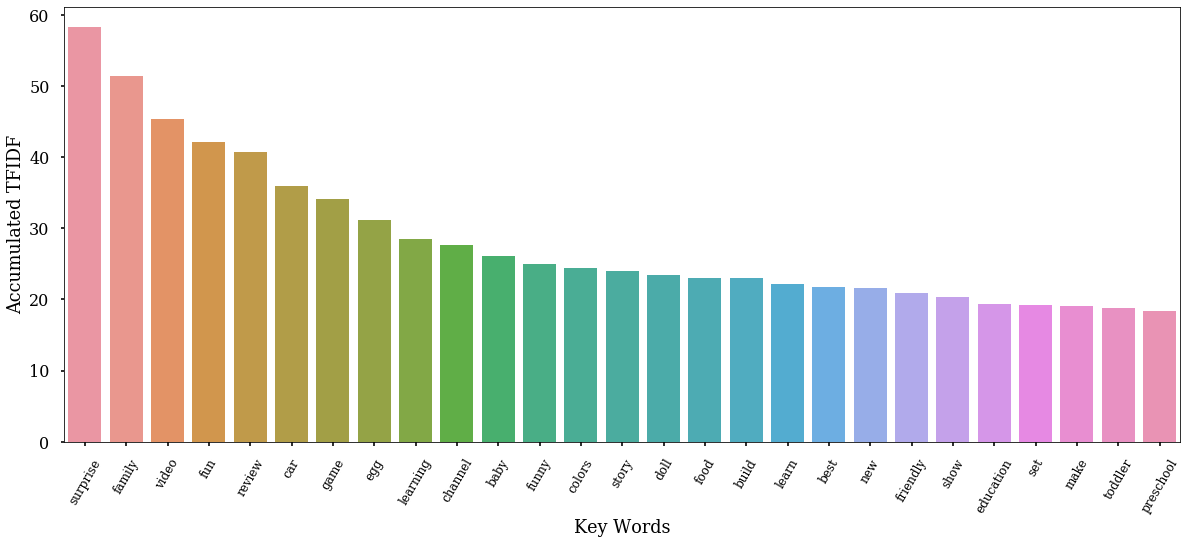

In [23]:
plt.figure(figsize = (20,8))
sns.barplot(x=first_30.index, y = first_30)
plt.xticks(rotation=60, fontsize=12)
plt.xlabel('Key Words')
plt.ylabel('Accumulated TFIDF')
plt.savefig('Tags_tfidf.pdf')

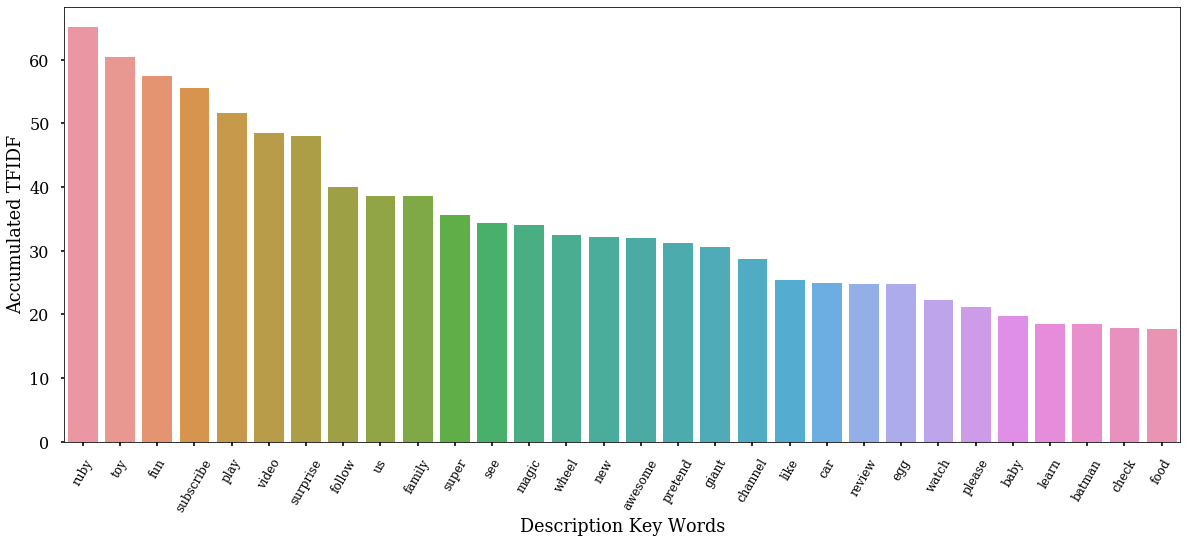

In [24]:
plt.figure(figsize = (20,8))
sns.barplot(x=frist_30_in_desc.index, y = frist_30_in_desc)
plt.xticks(rotation=60, fontsize=12)
plt.xlabel('Description Key Words')
plt.ylabel('Accumulated TFIDF')
plt.savefig('description_tfidf.pdf')